In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/drive/MyDrive/labeled_data_cleaned_whole.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Drop redundant column if it exists
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Tokenizer (Change to RoBERTa)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,  # Increased for more context
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Model (Change to RoBERTa)
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=1e-5)  # Reduced learning rate for stability
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 10
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# The rest of the code remains the same
# Evaluate model function, training loop, and other components stay unchanged.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-3-1ee9d6609bff>:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10


  0%|          | 0/574 [00:00<?, ?it/s]<ipython-input-3-1ee9d6609bff>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 574/574 [01:51<00:00,  5.13it/s]


Validation F1 Score for Hate Speech: 0.5089
Epoch 2/10


  0%|          | 0/574 [00:00<?, ?it/s]<ipython-input-3-1ee9d6609bff>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 574/574 [01:49<00:00,  5.26it/s]


Validation F1 Score for Hate Speech: 0.4856
Epoch 3/10


  0%|          | 0/574 [00:00<?, ?it/s]<ipython-input-3-1ee9d6609bff>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 574/574 [01:49<00:00,  5.26it/s]


Validation F1 Score for Hate Speech: 0.4490
Epoch 4/10


  0%|          | 0/574 [00:00<?, ?it/s]<ipython-input-3-1ee9d6609bff>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 574/574 [01:49<00:00,  5.26it/s]


Validation F1 Score for Hate Speech: 0.4733
Early stopping triggered.


<ipython-input-3-1ee9d6609bff>:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_roberta_model.pth"))


Test Metrics:
              precision    recall  f1-score   support

 Hate Speech       0.41      0.54      0.47       214
   Offensive       0.97      0.91      0.94      2879
     Neutral       0.83      0.95      0.89       625

    accuracy                           0.90      3718
   macro avg       0.74      0.80      0.76      3718
weighted avg       0.91      0.90      0.90      3718



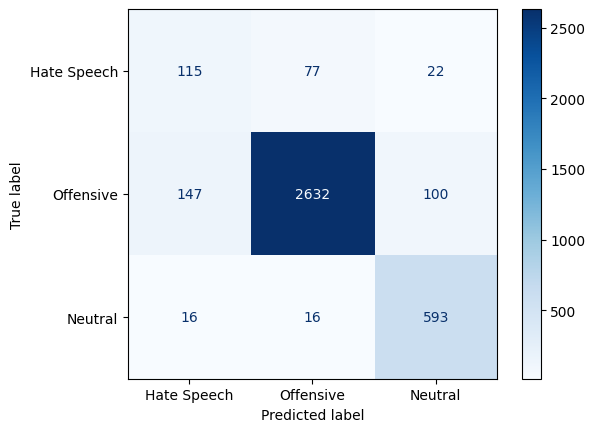

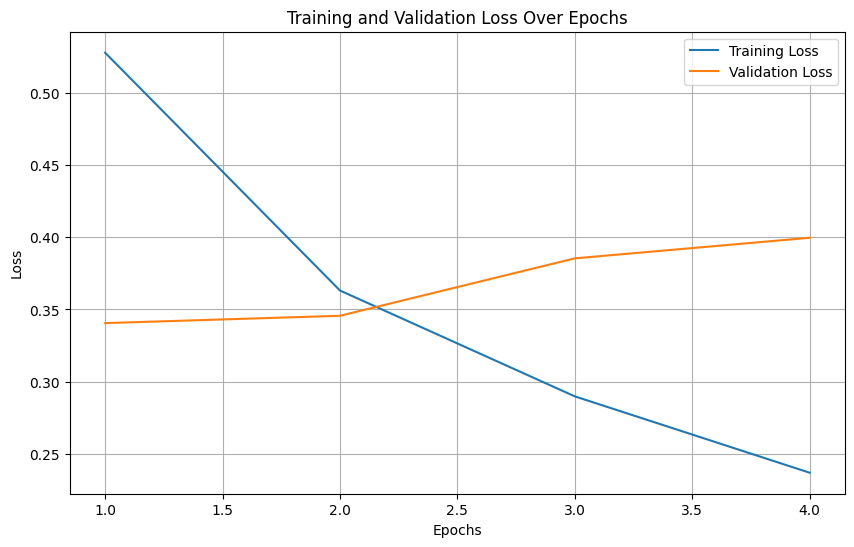

In [3]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/drive/MyDrive/labeled_data_cleaned_whole.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Drop redundant column if it exists
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Tokenizer (RoBERTa)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,  # Increased for more context
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Model (RoBERTa)
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=1e-5)  # Reduced learning rate for stability
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 10
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate model function
def evaluate_model(dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    return all_preds, all_labels, avg_loss

# Training Loop
scaler = GradScaler()
epochs = 10
best_val_f1 = 0
early_stopping_patience = 3
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_idx, batch in enumerate(tqdm(train_dataloader)):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    val_preds, val_labels, avg_val_loss = evaluate_model(val_dataloader)
    val_losses.append(avg_val_loss)

    val_report = classification_report(
        val_labels,
        val_preds,
        target_names=['Hate Speech', 'Offensive', 'Neutral'],
        output_dict=True
    )
    val_f1 = val_report['Hate Speech']['f1-score']
    print(f"Validation F1 Score for Hate Speech: {val_f1:.4f}")

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_roberta_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_roberta_model.pth"))
test_preds, test_labels, _ = evaluate_model(test_dataloader)
print("Test Metrics:")
print(classification_report(test_labels, test_preds, target_names=['Hate Speech', 'Offensive', 'Neutral']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hate Speech', 'Offensive', 'Neutral'])
disp.plot(cmap='Blues')
plt.show()

# Training and Validation Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-4-f7c8bb2befeb>:98: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/3


  0%|          | 0/574 [00:00<?, ?it/s]<ipython-input-4-f7c8bb2befeb>:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 574/574 [01:51<00:00,  5.13it/s]


Training Loss: 0.5315, Validation Loss: 0.3703
Epoch 2/3


100%|██████████| 574/574 [01:49<00:00,  5.26it/s]


Training Loss: 0.3612, Validation Loss: 0.3381
Epoch 3/3


100%|██████████| 574/574 [01:48<00:00,  5.27it/s]


Training Loss: 0.2913, Validation Loss: 0.3731


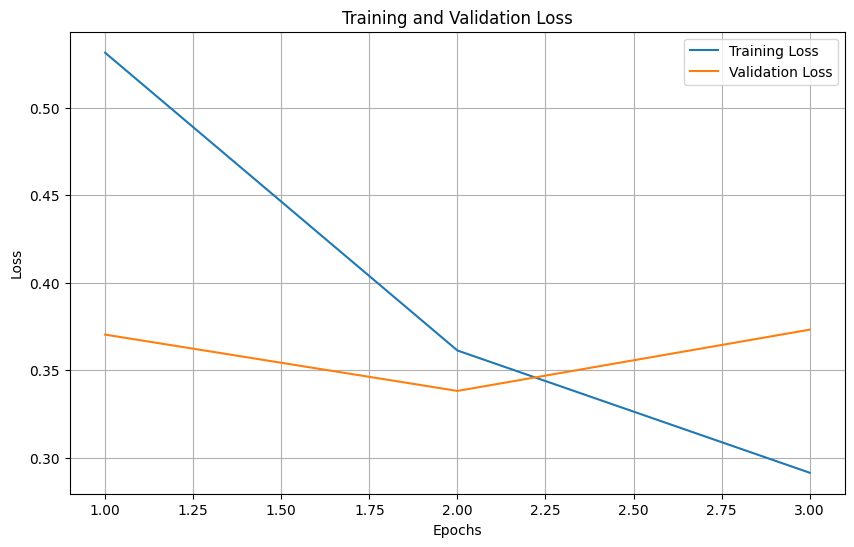

In [4]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/drive/MyDrive/labeled_data_cleaned_whole.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Drop redundant column if it exists
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# Clean tweets
def clean_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^A-Za-z0-9\s]", "", tweet)  # Remove special characters
    tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra spaces
    return tweet

data['tweet'] = data['corrected_tweet'].apply(clean_tweet)

# Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Balance the dataset (Oversampling Hate Speech class)
hate_speech = train_data[train_data['class'] == 0]
train_data_balanced = pd.concat([
    train_data,
    resample(hate_speech, replace=True, n_samples=1000, random_state=42)
])

# Tokenizer (RoBERTa)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_data(data):
    return tokenizer(
        data['tweet'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data)

# Define Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data_balanced['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

# Model (RoBERTa)
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Optimizer, scheduler, and class weights
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3
)

class_weights = torch.tensor([3.0, 1.0, 2.0], dtype=torch.float).to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training Loop with Loss Tracking
scaler = GradScaler()
epochs = 3
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")

    for batch in tqdm(train_dataloader):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()
